In [1]:
%matplotlib inline
from JAMA_config import *

In [4]:
def draw__Diagnostic_Metrics():
    '''
    Drawing Figure 3 in the main text.

    :return:
    '''
    labs = all_labs
    print 'draw__Diagnostic_Metrics for', labs, ' with label %s...'%result_label, 'at', data_source, ' of type,', lab_type 

    labs_stats_filepath = os.path.join(statsByLab_folderpath, 'summary-stats-bestalg-fixTrainPPV.csv')

    df = pd.read_csv(labs_stats_filepath, keep_default_na=False)

    # df = df[df['fixTrainPPV'] == targeted_PPV]

    df = df[df['lab'].isin(labs)]

    cached_foldername = 'Fig3_Diagnostic_Metrics/'
    cached_folderpath = os.path.join(os.path.join(statsByLab_folderpath, cached_foldername))

    cached_tablename = 'Diagnostic_Metrics_%ss_PPV_%.2f__%s.csv'%(lab_type, targeted_PPV, result_label)
    cached_tablepath = os.path.join(cached_folderpath, cached_tablename)

    cached_figurename = 'Diagnostic_Metrics_%ss_PPV_%.2f_ind__%s.png'%(lab_type, targeted_PPV, result_label)
    cached_figurepath = os.path.join(cached_folderpath, cached_figurename)

    if not os.path.exists(cached_folderpath):
        os.mkdir(cached_folderpath)

    if os.path.exists(cached_tablepath) and use_cached_fig_data:
        # lab2stats = pickle.load(open(cached_result_path, 'r'))
        print "%s exists!" % cached_tablepath
        df_toplots = pd.read_csv(cached_tablepath, keep_default_na=False)
        # print df_toplots

    else:
        print "%s does not exist!" % cached_tablepath
        if data_source == 'Stanford':
            # if 'total_vol' not in df.columns.values.tolist():
            # Stanford data, scaled by vol
            df['total_vol'] = df['total_vol_20140701_20170701']

        elif data_source == 'UCSF':
            if lab_type == 'panel':
                ucsf_lab_cnt = dict(stats_database.UCSF_PANELS_AND_COUNTS)

            elif lab_type == 'component':
                ucsf_lab_cnt = stats_database.UCSF_COMPONENT_TO_COUNT #dict(stats_database.UCSF_COMPONENTSS_AND_COUNTS)
            df['total_vol'] = df['lab'].apply(lambda x: ucsf_lab_cnt[x])
        elif data_source == 'UMich' and lab_type=='component' and result_label=='important_components':
            df = df[df['lab'].isin(stats_utils.umich_lab_cnt)]


            df['total_vol'] = df['lab'].apply(lambda x: stats_utils.umich_lab_cnt[x])
        else:
            df['total_vol'] = 1



        # TODO: use fractions in the original file!
        df['all_instance'] = df['TP'] + df['FP'] + df['TN'] + df['FN']

        for cnt_type in ['TP', 'FP', 'TN', 'FN']:
            df[cnt_type] = df[cnt_type]/df['all_instance']


        df['all_positive'] = df['TP'] + df['FP']

        # print df[['all_positive', 'total_vol']]
        df['predicted_normal_vol'] = df['all_positive'] * df['total_vol']


        if data_source == 'UMich' or data_source == 'UCSF':
            df['lab'] = df['lab'].apply(lambda x: map_lab(x, data_source, lab_type, map_type='from_src'))

        df = df[df['lab'].isin(stats_utils.get_important_labs('component'))]
        df['lab'] = pd.Categorical(
            df['lab'],
            categories=stats_utils.get_important_labs('component'),
            ordered=True
        )
        df = df.sort_values('lab')

        df['all_negative'] = df['TN'] + df['FN']

        df['TN'] = -df['TN']
        df['all_negative'] = -df['all_negative']


        lab_descriptions = stats_utils.get_lab_descriptions(data_source=data_source,#'Stanford',
                                                                 lab_type=lab_type)
        
        df['all_positive_vol'] = df['all_positive'] * df['total_vol']
        df['true_positive_vol'] = df['TP'] * df['total_vol']
        df['all_negative_vol'] = df['all_negative'] * df['total_vol']
        df['true_negative_vol'] = df['TN'] * df['total_vol']

        df_toplots = df #.iloc[:15]

        df_toplots[['lab',
                    'PPV', 'NPV', 'sens', 'spec', 'LR_p', 'LR_n',
                    'total_vol',
                   'all_positive_vol', 'true_positive_vol', 'all_negative_vol', 'true_negative_vol']]\
                    .to_csv(cached_tablepath, index=False, float_format='%.3f') # .sort_values('total_vol', ascending=False)\

        
    if not scale_by:
        scale = 1.
    elif scale_by=='pat':
        scale = float(stats_utils.NUM_DISTINCT_PATS/1000.)
    elif scale_by == 'enc':
        scale = float(stats_utils.NUM_DISTINCT_ENCS/1000.)
    elif scale_by == 'enc_ucsf':
        scale = float(stats_utils.NUM_DISTINCT_ENCS_UCSF/1000.)

    df_toplot = df_toplots.iloc[::-1]
    
    df_toplot = df_toplot[df_toplot['fixTrainPPV']==0.95]
    
    print df_toplot['lab'].values
    
    fig, ax = plt.subplots(figsize=(6, 9))

    ax.barh(df_toplot['lab'], df_toplot['all_positive_vol'] / scale, color='orangered', alpha=1,
            label='False Positive')
    ax.barh(df_toplot['lab'], df_toplot['true_positive_vol'] / scale, color='forestgreen', alpha=1,
            label='True Positive')
    ax.barh(df_toplot['lab'], df_toplot['all_negative_vol'] / scale, color='gold', alpha=1,
            label='False Negative')
    ax.barh(df_toplot['lab'], df_toplot['true_negative_vol'] / scale, color='royalblue', alpha=1,
            label='True Negative')

    plt.yticks([])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(False)


    plt.tick_params('x', labelsize=24)

    plt.legend()
    plt.tight_layout()

    plt.savefig(cached_figurepath)

draw__Diagnostic_Metrics for ['WBC', 'HGB', 'PLT', 'NA', 'K', 'CR', 'BUN', 'CO2', 'CA', 'TP', 'ALB', 'ALKP', 'TBIL', 'AST', 'ALT']  with label important_components... at Stanford  of type, component
/Users/songxu/healthrex/CDSS/scripts/LabTestAnalysis/lab_statistics/data-Stanford-component-10000-episodes-lastnormal/Fig3_Diagnostic_Metrics/Diagnostic_Metrics_components_PPV_0.95__important_components.csv does not exist!
[ALT, AST, TBIL, ALKP, TP, ..., K, NA, PLT, HGB, WBC]
Length: 15
Categories (15, object): [WBC < HGB < PLT < NA ... ALKP < TBIL < AST < ALT]
draw__Diagnostic_Metrics for ['WBC', 'HGB', 'PLT', 'NA', 'K', 'CREAT', 'TBILI', 'CO2', 'AST', 'ALT', 'ALB', 'CA', 'TP', 'ALKP', 'BUN']  with label important_components... at UCSF  of type, component
/Users/songxu/healthrex/CDSS/scripts/LabTestAnalysis/lab_statistics/data-UCSF-component-10000-episodes-lastnormal/Fig3_Diagnostic_Metrics/Diagnostic_Metrics_components_PPV_0.95__important_components.csv does not exist!
[ALT, AST, TBIL, AL

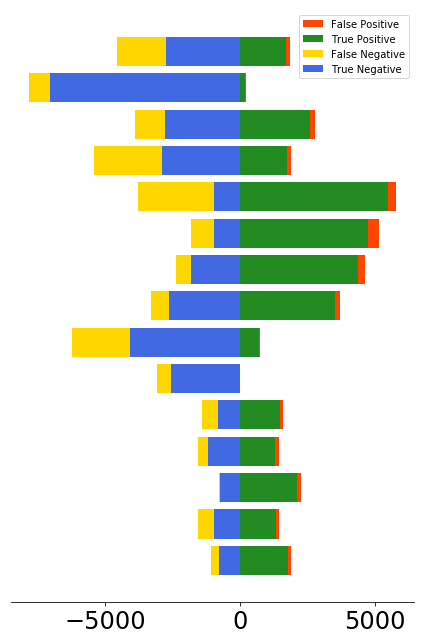

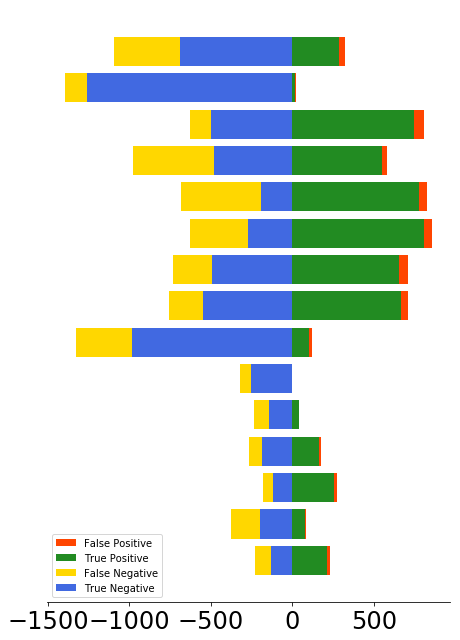

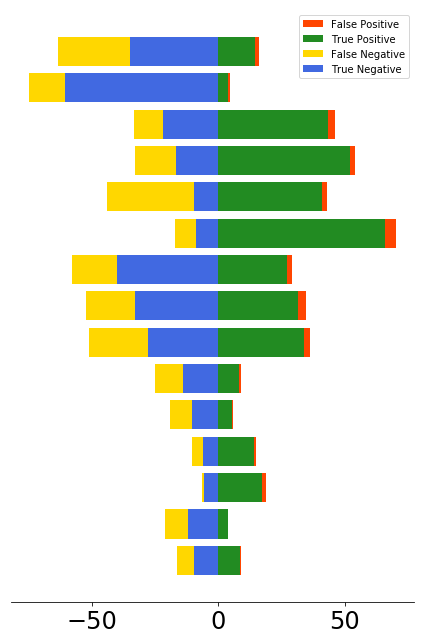

In [5]:
targeted_PPV=0.95
scale_by='enc'
use_cached_fig_data=False
result_label = 'important_components'
inverse01=inverse01
for data_source in ['Stanford', 'UCSF', 'UMich']: # 
    for lab_type in ['component']:
        dataset_foldername = 'data-%s-%s-%s'%(data_source, lab_type, curr_version)
        labStats_folderpath = os.path.join(LocalEnv.PATH_TO_CDSS, 'scripts/LabTestAnalysis/lab_statistics')
        statsByLab_folderpath = os.path.join(labStats_folderpath, dataset_foldername)
        if data_source == 'Stanford' and lab_type == 'component':
            all_labs = STRIDE_COMPONENT_TESTS_common#
        elif data_source == 'UMich' and lab_type == 'component':
            all_labs = UMICH_TOP_COMPONENTS_common#
        elif data_source == 'UCSF' and lab_type == 'component':
            all_labs = UCSF_TOP_COMPONENTS_common #
            
        '''
        Two steps: 
        lab2stats: Getting lab-wise stats tables under lab_statistics/dataset_folder/stats_by_lab_alg/..
        stats2summary: Aggregate all labs' stats under lab_statistics/dataset_folder/..
        '''
        draw__Diagnostic_Metrics()